### Demo

In [2]:
import math
import cmath

def dft(x):
    """
    Discrete Fourier Transform (forward), unnormalized.
    x: list/tuple of real or complex samples (length N).
    Returns: list of N complex numbers X[k].
    
    X[k] = sum_{n=0}^{N-1} x[n] * e^{-j 2π k n / N}
    """
    N = len(x)
    X = []
    for k in range(N):
        s = 0j
        for n in range(N):
            angle = -2 * math.pi * k * n / N
            s += x[n] * complex(math.cos(angle), math.sin(angle))
        X.append(s)
    return X

def idft(X):
    """
    Inverse Discrete Fourier Transform (inverse), matching the above scaling.
    Returns: list of N complex numbers x[n].

    x[n] = (1/N) * sum_{k=0}^{N-1} X[k] * e^{+j 2π k n / N}
    """
    N = len(X)
    x = []
    for n in range(N):
        s = 0j
        for k in range(N):
            angle =  2 * math.pi * k * n / N
            s += X[k] * complex(math.cos(angle), math.sin(angle))
        x.append(s / N)
    return x

# --- tiny demo ---
if __name__ == "__main__":
    # A toy real signal: two tones on N=8 samples
    N = 8
    x = [math.sin(2*math.pi*1*n/N) + 0.5*math.sin(2*math.pi*2*n/N) for n in range(N)]

    X = dft(x)
    x_rec = idft(X)

    print("Magnitudes (first half):", [round(abs(v), 3) for v in X[:N//2]])
    max_err = max(abs((x[n] - x_rec[n]).real) for n in range(N))
    print("Reconstruction max error:", max_err)


Magnitudes (first half): [0.0, 4.0, 2.0, 0.0]
Reconstruction max error: 1.1102230246251565e-15


In [3]:
import numpy as np

def dft(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    for k in range(N):
        for n in range(N):
            X[k] += x[n] * np.exp(-2j * np.pi * k * n / N)
    return X

# Example usage:
signal = np.array([1, 2, 3, 4])
dft_result = dft(signal)
print(dft_result)

[10.+0.00000000e+00j -2.+2.00000000e+00j -2.-9.79717439e-16j
 -2.-2.00000000e+00j]


True shift:      (dy, dx) = (9, -7)
Estimated shift: (dy, dx) = (9, -7)


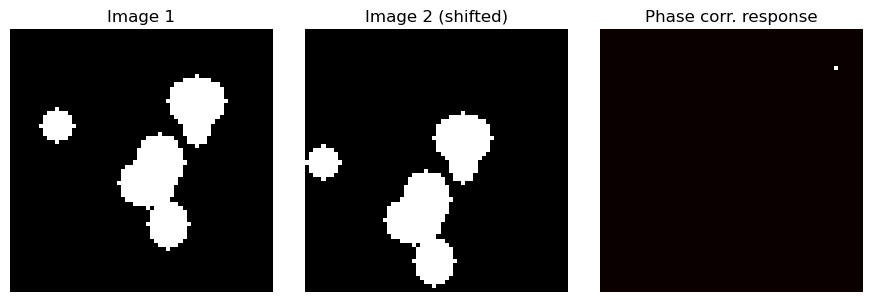

In [4]:
import math, cmath
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Plain DFT / IDFT (1D)
# -----------------------------
def dft(x):
    """Forward DFT (unnormalized). x: iterable of real/complex."""
    x = list(x)
    N = len(x)
    X = []
    for k in range(N):
        s = 0j
        for n in range(N):
            angle = -2 * math.pi * k * n / N
            s += x[n] * complex(math.cos(angle), math.sin(angle))
        X.append(s)
    return X

def idft(X):
    """Inverse DFT matching the scaling above."""
    X = list(X)
    N = len(X)
    x = []
    for n in range(N):
        s = 0j
        for k in range(N):
            angle =  2 * math.pi * k * n / N
            s += X[k] * complex(math.cos(angle), math.sin(angle))
        x.append(s / N)
    return x

# -----------------------------
# 2) 2D DFT / IDFT via separability
# -----------------------------
def dft2(img):
    """
    2D DFT by: DFT rows -> DFT columns.
    img: 2D real/complex ndarray (small, e.g., 64x64).
    returns complex ndarray of same shape.
    """
    M, N = img.shape
    # Row transforms
    tmp = np.empty((M, N), dtype=complex)
    for i in range(M):
        tmp[i, :] = dft(img[i, :])
    # Column transforms
    F = np.empty((M, N), dtype=complex)
    for j in range(N):
        F[:, j] = dft(tmp[:, j])
    return F

def idft2(F):
    """
    2D IDFT by: IDFT columns -> IDFT rows (inverse order).
    F: 2D complex ndarray.
    returns complex ndarray of same shape.
    """
    M, N = F.shape
    # Column inverse
    tmp = np.empty((M, N), dtype=complex)
    for j in range(N):
        tmp[:, j] = idft(F[:, j])
    # Row inverse
    img = np.empty((M, N), dtype=complex)
    for i in range(M):
        img[i, :] = idft(tmp[i, :])
    return img

# -----------------------------
# 3) Build a tiny synthetic image and a shifted copy
# -----------------------------
M = N = 64
img = np.zeros((M, N), dtype=float)

# Draw a few white blobs (ellipses) for structure
rng = np.random.default_rng(0)
for _ in range(6):
    cy, cx = rng.integers(10, M-10), rng.integers(10, N-10)
    ry, rx = rng.integers(4,8), rng.integers(4,8)
    yy, xx = np.ogrid[:M, :N]
    mask = ((yy - cy)**2) / (ry**2) + ((xx - cx)**2) / (rx**2) <= 1.0
    img[mask] = 1.0

# Apply an integer translation (dy, dx)
true_dy, true_dx = 9, -7
img_shift = np.roll(np.roll(img, true_dy, axis=0), true_dx, axis=1)

# -----------------------------
# 4) Phase correlation using DFT/IDFT (no FFT)
# -----------------------------
F1 = dft2(img)
F2 = dft2(img_shift)

# Cross-power spectrum (normalize magnitude to 1 to keep only phase)
R = F2 * np.conj(F1)
R_mag = np.abs(R)
R_norm = R / (R_mag + 1e-12)

# Correlation surface is inverse DFT of normalized cross-power spectrum
r = idft2(R_norm)
r_abs = np.abs(r)

# Peak location -> estimated integer shift (wrap to signed)
py, px = np.unravel_index(np.argmax(r_abs), r_abs.shape)
est_dy = py if py < M//2 else py - M
est_dx = px if px < N//2 else px - N

print(f"True shift:      (dy, dx) = ({true_dy}, {true_dx})")
print(f"Estimated shift: (dy, dx) = ({est_dy}, {est_dx})")

# -----------------------------
# 5) Plots
# -----------------------------
plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title('Image 1'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(img_shift, cmap='gray'); plt.title('Image 2 (shifted)'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(r_abs, cmap='hot'); plt.title('Phase corr. response'); plt.axis('off')
plt.tight_layout(); plt.show()
